# Opdracht 3: Intro to agents and agent-tools
## Tutorial: Kings of mesa

In [1]:
from mesa import Agent, Model
from mesa.batchrunner import BatchRunner
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from mesa.space import MultiGrid

from random import randint
import matplotlib.pyplot as plt


## Money Model

In [2]:
class MoneyModel(Model):
    """A model with some number of agents.
    """
    def __init__(self, N, width, height):
        """Creates the model with a certain amount of agents N

        Args:
            N (int): The amount of agents in the model
            width (int): The width of the simulation's grid
            height (int): The height of the simulation's grid
        """
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.running = True

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            print(f"Created agent with ID:{a.unique_id}  \tWith wealth:{a.wealth}")
            self.schedule.add(a)

            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini},  # `compute_gini` defined above
            agent_reporters={"Wealth": "wealth"})

    def step(self):
        '''Advance the model by one step.'''
        self.schedule.step()
        self.datacollector.collect(self)


## Money Agent

In [3]:
class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = randint(1,3)
        self.unique_id = unique_id

    def move(self):
        """
        This function will make the agent move to a new place in the grid 
        """
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        """
        This function gives money to another agent in the gridcell
        """
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1
    
    def step(self):
        """
        Every step the agents move to a new place, and if the agents has money it will give it to a gridcell mate 
        """
        self.move()
        if self.wealth > 0:
            self.give_money()
    
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum( xi * (N-i) for i,xi in enumerate(x) ) / (N*sum(x))
    return (1 + (1/N) - 2*B)


## Batch
This codecell creates batches of the code and runs them,
each model in the batch has the same grid the only variable that chances is the number of agents in the simulation.

In [4]:
fixed_params = {
    "width": 10,
    "height": 10}

variable_params = {"N": range(10, 500, 10)}

batch_run = BatchRunner(
    MoneyModel,
    variable_params,
    fixed_params,
    iterations=5,
    max_steps=100,
    model_reporters={"Gini": compute_gini})

batch_run.run_all()

 with ID:11  	With wealth:3
Created agent with ID:12  	With wealth:3
Created agent with ID:13  	With wealth:3
Created agent with ID:14  	With wealth:1
Created agent with ID:15  	With wealth:3
Created agent with ID:16  	With wealth:3
Created agent with ID:17  	With wealth:3
Created agent with ID:18  	With wealth:3
Created agent with ID:19  	With wealth:3
Created agent with ID:20  	With wealth:2
Created agent with ID:21  	With wealth:1
Created agent with ID:22  	With wealth:2
Created agent with ID:23  	With wealth:1
Created agent with ID:24  	With wealth:3
Created agent with ID:25  	With wealth:1
Created agent with ID:26  	With wealth:1
Created agent with ID:27  	With wealth:3
Created agent with ID:28  	With wealth:2
Created agent with ID:29  	With wealth:2
Created agent with ID:30  	With wealth:2
Created agent with ID:31  	With wealth:1
Created agent with ID:32  	With wealth:1
Created agent with ID:33  	With wealth:1
Created agent with ID:34  	With wealth:2
Created agent with ID:35  	Wi

Visualisation of the gini coefficient in our simulation

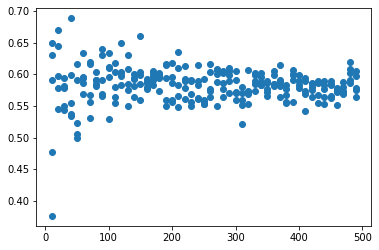

In [5]:
batch_data = batch_run.get_model_vars_dataframe()

plt.scatter(batch_data.N, batch_data.Gini)
plt.show()

## Theorie
### Vraag 1
Ik heb de tutorial over Mesa gevolgd "King of the Mesa", en in Mesa het MoneyModel gecreert. Mesa is een python module waardoor het makkelijk te gebruiken is en er dat je hierdoor ook gebruik kan maken van de vele andere python modules in je Mesa Model. omdat Python al een taal is die ik ken is mesa snel optepakken. naast dit is het met mesa ook heel gemakkelijk om veel runs te maken met vele verschillende parameters. het nadeel van mesa is dat het niet zo makkelijk is als bijvoorbeeld met netlogo om een visualisatie te maken van de simulatie.

### Vraag 2
1.	An initial internal state:<br>
bij mij Agent zijn er 2 initial internal state's de locatie van waar die zich bevindt en het vermogen "wealth" dat de agent heeft. 
2.	A function, See or Perceive:<br>
elke 'step', als de agent geld heeft, wordt de fucntie 'give_money()' uitgevoerd. in deze functie kan de agent als waren "kijken" welke agents er allemaal bij hem in de gridcell.
3.	A function act: <br>
Act gebeurd in dezelfde step,"give_money()", waarbij nadat de agent een andere agent in zijn cell heeft gezien, hij een geld stuk geeft aan de andere agent. als de agent meerdere agents ziet zal hij een random keuze uit de agents maken waar de agent zijn geld aan geeft. ziet de agent niemand in zijn cell? dan zal de agent deze stap geen geld geven en behoud hij het zelfde vermogen "wealth"
4.	A function update<br>
de update function is de "move()" function waarbij de agent kijkt ("perception") welke mogelijke gridcellen allemaal mogelijk zijn om naar toe te verplaatsen en dan zijn positie veranderd naar een van de mogelijkheden. 

### Vraag 3
1. Accessible vs inaccessible<br>
de omgeving is **inaccessible** de enige informatie dat de agents hebben is of er andere agents bij hem in de gridcell staan of niet. waarbij de agent ook niks anders weet dan hun locatie.
2. Deterministic vs non-Deterministic (Stochastic)<br>
de omgeving is **non-Deterministic** er is veel randomness in de simulatie, waar de agents naar toebewegen en de initial wealth van de agents, hierdoor is er in elke staat van de simulatie dus onzekerheid welke actie tot welk gevolg zal leiden.
3. Episodic vs non-episodic (Sequential)<br>
de omgeving is **Episodic** De agents beslissen perstap wat zij doen en hun acties hangen af wat de gevolgen zijn van hun vorige acties.
4. Static vs Dynamic<br>
de omgeving is **Static** de enviroment,de "grid", verandert niets allen de agent’s wealth en locatie veranderen.
5. Discrete vs continuous<br>
de omgeving is **Discrete** omdat er een limiet zit op het aantal acties en de perceptions van de agent.

### Vraag 4
1. Accessible vs inaccessible.<br>
met de huidig code zou het niks verandere aan de simulatie te als het veranderend wordt naar Accessible. maar als de agents meer informatie,dus meer acces, zouden hebben over bijvoorbeeld waar ander agents zijn over her geheel van de grid. zou het in het belang zijn van de agent om te bewegen naar een gridcell waar geen mede agents zijn zodat hij zijn vermogen,"wealth", kan behouden
2. Deterministic vs non-Deterministic<br>
als we de simulatie meer Deterministich maken zal de gehele simulatie niet meer interessant zijn. het willikeurige van simuatatie is juist een must omdat het op het "soort" gedrag van mensen moet lijken en dit gedrag is random. 
3. Episodic vs non-episodic<br>
Als we de simulatie veranderen naar non-episodic. zouden de agents naar het veleden kunnen kijken. dit zou beteken of zij kunnen weten of zij aan een bepaalde agent al geld hebben gegeven. maar dit zal niks veranderen aan onze simulatie omdat de agent de keuze van de agent al vast staat en de agent geld moet geven als hij wealth heeft en er agents bij hem in de cell staan.

